In [1]:
!pip install -U awscli
!pip install sagemaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 28.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 44.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.83
    Uninstalling botocore-1.34.83:
      Successfully uninstalled botocore-1.34.83
  Attempting uninstall: awscli
    Found existing installation: awscli 1.32.83
    Uninstalling awscli-1.32.83:
      Successfully uninstalled awscli-1.32.83


In [2]:
%matplotlib inline

import time
import os
import boto3
import botocore
import re
import json
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name

# You can use a different IAM role with "SageMakerFullAccess" policy for this notebook
role = get_execution_role()
print(f"Execution role: {role}")

sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = sm_session.default_bucket()
prefix = "sagemaker/DEMO-Deployment-Guardrails-Canary"

Matplotlib is building the font cache; this may take a moment.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Execution role: arn:aws:iam::820129967772:role/LabRole


#### download input and pre trained files

In [3]:
!aws s3 cp s3://sagemaker-sample-files-final-sree/models/xgb-churn/17-17-01-46-015-model.tar model/
!aws s3 cp s3://sagemaker-sample-files-final-sree/models/xgb-churn/17-17-01-46-017-model.tar model/

!aws s3 cp s3://sagemaker-sample-files-final-sree/datasets/tabular/test_projeect.csv test_data/

download: s3://sagemaker-sample-files-final-sree/models/xgb-churn/17-17-01-46-015-model.tar to model/17-17-01-46-015-model.tar
download: s3://sagemaker-sample-files-final-sree/models/xgb-churn/17-17-01-46-017-model.tar to model/17-17-01-46-017-model.tar
download: s3://sagemaker-sample-files-final-sree/datasets/tabular/test_projeect.csv to test_data/test_projeect.csv


### Step 1: Create and deploy the models

In [7]:
from sagemaker.s3 import S3Uploader

model_url = S3Uploader.upload(
    local_path="model/17-17-01-46-015-model.tar",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)
model_url2 = S3Uploader.upload(
    local_path="model/17-17-01-46-017-model.tar",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)

print(f"Model URI 1: {model_url}")
print(f"Model URI 2: {model_url2}")

Model URI 1: s3://sagemaker-us-east-1-820129967772/sagemaker/DEMO-Deployment-Guardrails-Canary/17-17-01-46-015-model.tar
Model URI 2: s3://sagemaker-us-east-1-820129967772/sagemaker/DEMO-Deployment-Guardrails-Canary/17-17-01-46-017-model.tar


### Next, we create our model definitions
Start with deploying the pre-trained churn prediction models. Here, you create the model objects with the image and model data. The three URIs correspond to the baseline version, the update containing the incompatible version, and the update containing the correct model version.

In [8]:
from sagemaker import image_uris

image_uri = image_uris.retrieve("xgboost", boto3.Session().region_name, "0.90-1")

# using newer version of XGBoost which is incompatible, in order to simulate model faults
image_uri2 = image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-1")
image_uri3 = image_uris.retrieve("xgboost", boto3.Session().region_name, "0.90-2")

print(f"Model Image 1: {image_uri}")
print(f"Model Image 2: {image_uri2}")
print(f"Model Image 3: {image_uri3}")

Model Image 1: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3
Model Image 2: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1
Model Image 3: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3


In [10]:
model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"DEMO-xgb-churn-pred3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Model Name 1: {model_name}")
print(f"Model Name 2: {model_name2}")
print(f"Model Name 3: {model_name3}")

resp = sm.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri, "ModelDataUrl": model_url}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri2, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")

resp = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{"Image": image_uri3, "ModelDataUrl": model_url2}],
)
print(f"Created Model: {resp}")

Model Name 1: DEMO-xgb-churn-pred-2024-04-18-03-29-58
Model Name 2: DEMO-xgb-churn-pred2-2024-04-18-03-29-58
Model Name 3: DEMO-xgb-churn-pred3-2024-04-18-03-29-58
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:820129967772:model/DEMO-xgb-churn-pred-2024-04-18-03-29-58', 'ResponseMetadata': {'RequestId': '8335ca31-9120-4dcd-9959-078e9c298543', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '8335ca31-9120-4dcd-9959-078e9c298543', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Thu, 18 Apr 2024 03:29:58 GMT'}, 'RetryAttempts': 0}}
Created Model: {'ModelArn': 'arn:aws:sagemaker:us-east-1:820129967772:model/DEMO-xgb-churn-pred2-2024-04-18-03-29-58', 'ResponseMetadata': {'RequestId': '353e0256-6bd3-4402-ae51-4565f3b54b72', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '353e0256-6bd3-4402-ae51-4565f3b54b72', 'content-type': 'application/x-amz-json-1.1', 'content-length': '102', 'date': 'Thu, 18 Apr 2024 03:29:59 GMT'}, 'Retry

### Create Endpoint Configs
We now create three EndpointConfigs, corresponding to the three Models we created in the previous step.

In [11]:
ep_config_name = f"DEMO-EpConfig-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name2 = f"DEMO-EpConfig-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name3 = f"DEMO-EpConfig-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 1: {ep_config_name}")
print(f"Endpoint Config 2: {ep_config_name2}")
print(f"Endpoint Config 3: {ep_config_name3}")

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name2,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name2,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

resp = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"Created Endpoint Config: {resp}")
time.sleep(5)

Endpoint Config 1: DEMO-EpConfig-1-2024-04-18-03-30-02
Endpoint Config 2: DEMO-EpConfig-2-2024-04-18-03-30-02
Endpoint Config 3: DEMO-EpConfig-3-2024-04-18-03-30-02
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint-config/DEMO-EpConfig-1-2024-04-18-03-30-02', 'ResponseMetadata': {'RequestId': '40f7be7f-81a3-4c45-af26-543e465ebe7a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '40f7be7f-81a3-4c45-af26-543e465ebe7a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Thu, 18 Apr 2024 03:30:01 GMT'}, 'RetryAttempts': 0}}
Created Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint-config/DEMO-EpConfig-2-2024-04-18-03-30-02', 'ResponseMetadata': {'RequestId': 'ef34a31c-4638-4ddf-a6d1-4916156c2db9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ef34a31c-4638-4ddf-a6d1-4916156c2db9', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116'

### Create Endpoint
Deploy the baseline model to a new SageMaker endpoint:

In [12]:
endpoint_name = f"DEMO-Deployment-Guardrails-Canary-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Endpoint Name: {endpoint_name}")

resp = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=ep_config_name)
print(f"\nCreated Endpoint: {resp}")

Endpoint Name: DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17

Created Endpoint: {'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17', 'ResponseMetadata': {'RequestId': '7dc5b617-0ea0-478f-a4e4-8f3b77b41042', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7dc5b617-0ea0-478f-a4e4-8f3b77b41042', 'content-type': 'application/x-amz-json-1.1', 'content-length': '121', 'date': 'Thu, 18 Apr 2024 03:30:17 GMT'}, 'RetryAttempts': 0}}


#### wait for the endpoint to create

In [13]:
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service
......
Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-04-18-03-30-02',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 669000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 129000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 18, 3, 33, 3, 359000, tzinfo=tzlo

### Step 2: Invoke Endpoint 
You can now send data to this endpoint to get inferences in real time.

This step invokes the endpoint with included sample data with maximum invocations count and waiting intervals.

In [14]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_data/test_projeect.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e
            count += 1
            if count > max_invocations:
                break
            time.sleep(wait_interval_sec)

    print("\nDone!")


invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17. 
Please wait...
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Done!


### Invocations Metrics
Amazon SageMaker emits metrics such as Latency and Invocations per variant/Endpoint Config.

In [15]:
import pandas as pd

cw = boto3.Session().client("cloudwatch", region_name=region)


def get_sagemaker_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    if endpoint_config_name is not None:
        dimensions.append({"Name": "EndpointConfigName", "Value": endpoint_config_name})
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
    rename = endpoint_config_name if endpoint_config_name is not None else "ALL"
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: rename})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=60)
    end_time = datetime.now(timezone.utc)
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    if metrics_variants is None:
        return
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

### Plot endpoint invocation metrics:
Below, we are going to plot graphs to show the Invocations,Invocation4XXErrors,Invocation5XXErrors,ModelLatency and OverheadLatency against the Endpoint.

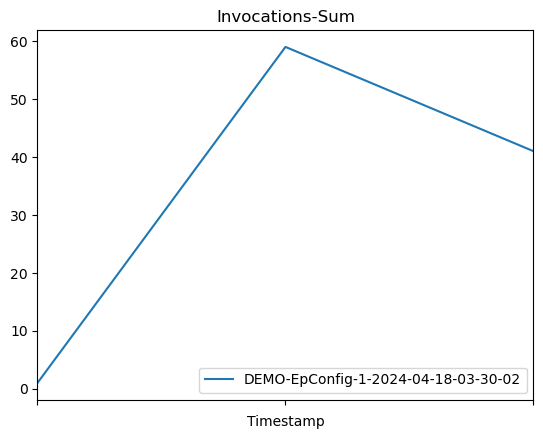

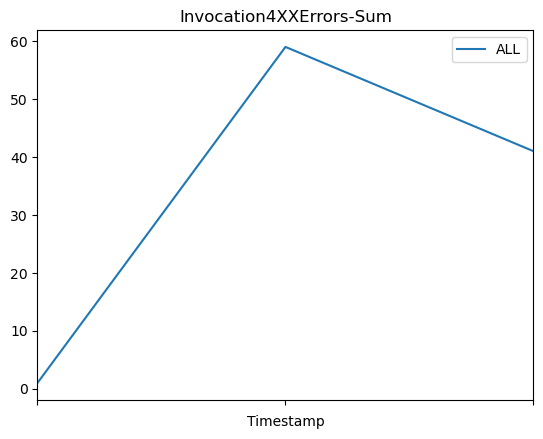

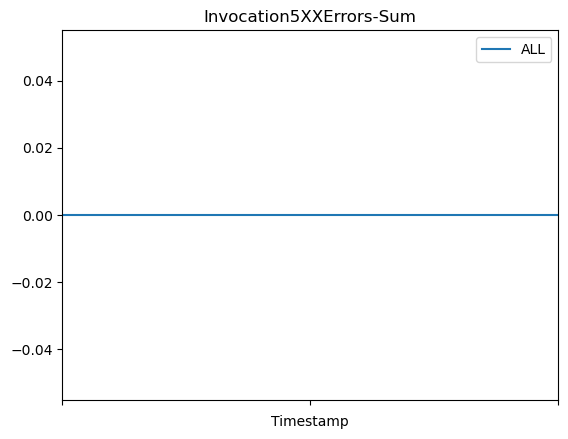

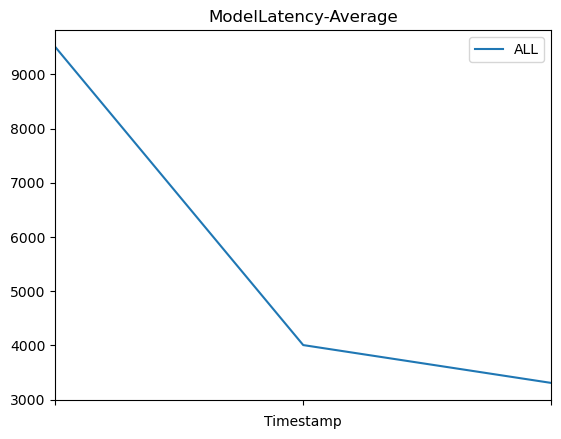

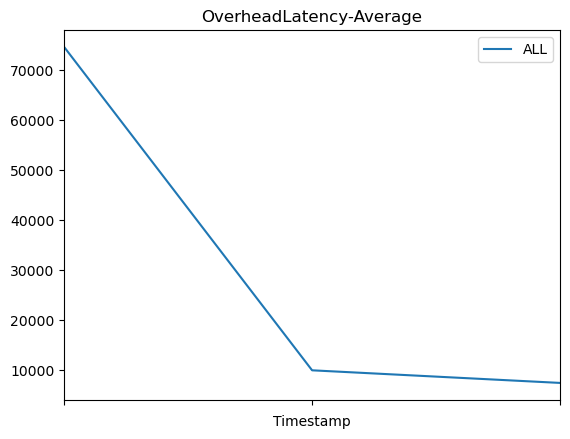

In [16]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

### Step 3: Create CloudWatch alarms to monitor Endpoint performance 
Create CloudWatch alarms to monitor Endpoint performance with following metrics:

Invocation5XXErrors
ModelLatency
#### Following metric dimensions are used to select the metric per Endpoint config and variant:

EndpointName
VariantName

In [17]:
def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [18]:
error_alarm = f"TestAlarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"

# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 1
)
# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000
)

In [19]:
cw.describe_alarms(AlarmNames=[error_alarm, latency_alarm])
time.sleep(60)

### Step 4: Update Endpoint with deployment configurations 
Update the endpoint with deployment configurations and monitor the performance from CloudWatch metrics.

#### Rollback Case
Update the Endpoint with an incompatible model version to simulate errors and trigger a rollback.


In [20]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT",  # or use "CAPACITY_PERCENT" as 30%, 50%
                "Value": 1,
            },
            "WaitIntervalInSeconds": 300,  # wait for 5 minutes before enabling traffic on the rest of fleet
        },
        "TerminationWaitInSeconds": 120,  # wait for 2 minutes before terminating the old stack
        "MaximumExecutionTimeoutInSeconds": 1800,  # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}],
    },
}

# update endpoint request with new DeploymentConfig parameter
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name2,
    DeploymentConfig=canary_deployment_config,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'ResponseMetadata': {'RequestId': '2d7efebb-156d-4fe5-9e0e-2c9c00afaef6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2d7efebb-156d-4fe5-9e0e-2c9c00afaef6',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Thu, 18 Apr 2024 03:39:15 GMT'},
  'RetryAttempts': 0}}

In [21]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointConfigName': 'DEMO-EpConfig-1-2024-04-18-03-30-02',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:4814427c3e0a6cf99e637704da3ada04219ac7cd5727ff62284153761d36d7d3',
     'ResolutionTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 669000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'Updating',
 'CreationTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 129000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 18, 3, 39, 16, 428000, tzinfo=tzlo

### We invoke the endpoint during the update operation is in progress.
Note : Invoke endpoint in this notebook is in single thread mode, to stop the invoke requests please stop the cell execution

The E's denote the errors generated from the incompatible model version in the canary fleet.

The purpose of the below cell is to simulate errors in the canary fleet. Since the nature of traffic shifting to the canary fleet is probabilistic, you should wait until you start seeing errors. Then, you may proceed to stop the execution of the below cell. If not aborted, cell will run for 600 invocations.

In [33]:
invoke_endpoint(endpoint_name)

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

#### Wait for the update operation to complete and verify the automatic rollback.

In [23]:
wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

Waiting for endpoint in service

Done!


{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointConfigName': 'DEMO-EpConfig-2-2024-04-18-03-30-02',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:99404b884e2fd647e7430c583d58ffddffb72a7feccd19e96127a0ffb384b4df',
     'ResolutionTime': datetime.datetime(2024, 4, 18, 3, 39, 16, 639000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 129000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 18, 3, 49, 25, 35000, tzinfo=tzlocal()),
 

##### Collect the endpoint metrics during the deployment:

Below, we are going to plot graphs to show the Invocations,Invocation5XXErrors and ModelLatency against the Endpoint.
You can expect to see as the new endpoint config-2 (erroneous due to model version) starts getting deployed, it encounters failure and leads to the rollback to endpoint config-1. This can be seen in the graphs below as the Invocation5XXErrors and ModelLatency increases during this rollback phase

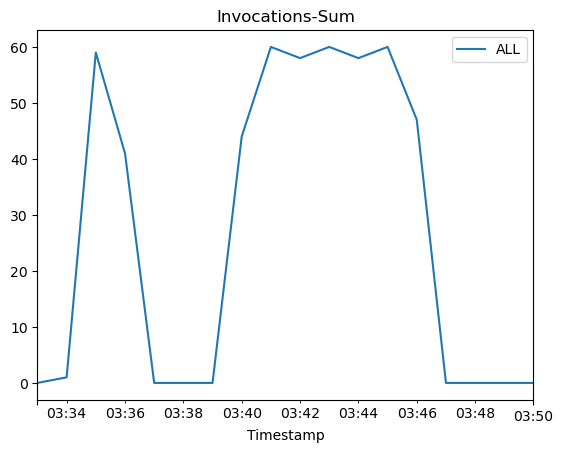

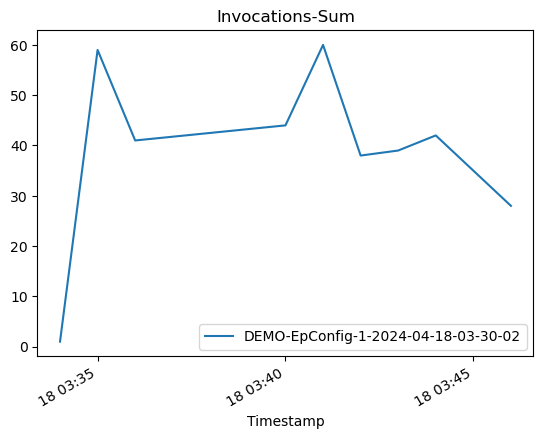

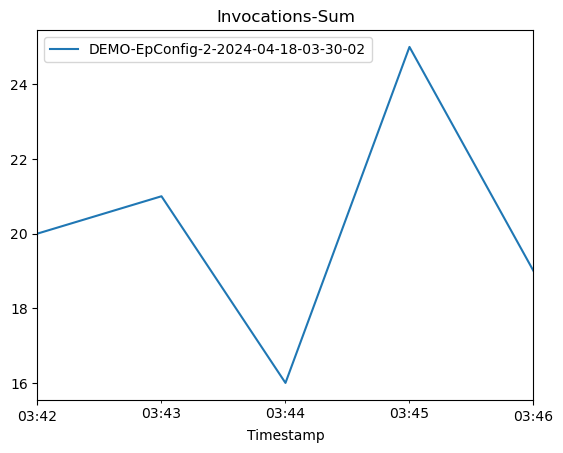

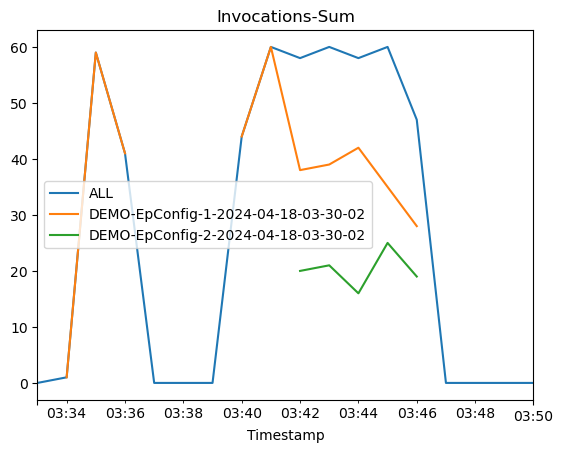

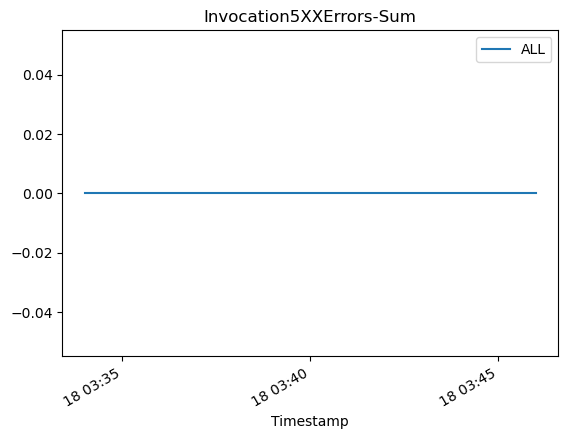

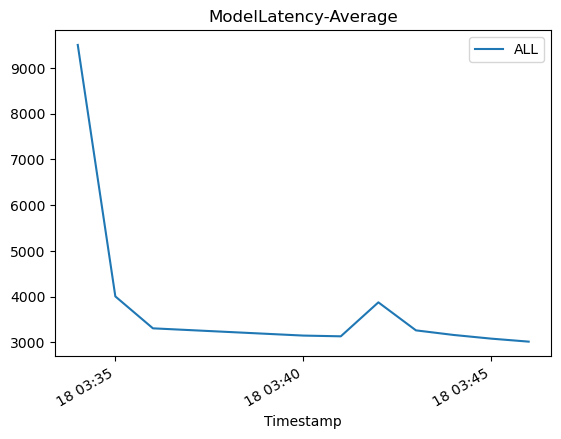

In [24]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

Let's take a look at the Success case where we use the same Canary deployment configuration but a valid endpoint configuration.

Success Case


Now we show the success case where the Endpoint Configuration is updated to a valid version (using the same Canary deployment config as the rollback case).

Update the endpoint with the same Canary deployment configuration:

In [25]:
# update endpoint with a valid version of DeploymentConfig

sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name3,
    RetainDeploymentConfig=True,
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'ResponseMetadata': {'RequestId': 'edd1b1eb-57ba-4de6-9ce9-b3065dbb907b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'edd1b1eb-57ba-4de6-9ce9-b3065dbb907b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Thu, 18 Apr 2024 03:53:23 GMT'},
  'RetryAttempts': 0}}

In [26]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointConfigName': 'DEMO-EpConfig-2-2024-04-18-03-30-02',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:99404b884e2fd647e7430c583d58ffddffb72a7feccd19e96127a0ffb384b4df',
     'ResolutionTime': datetime.datetime(2024, 4, 18, 3, 39, 16, 639000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'Updating',
 'CreationTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 129000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 18, 3, 53, 24, 882000, tzinfo=tzlocal()),
 

Invoke the endpoint during the update operation is in progress:

In [27]:
invoke_endpoint(endpoint_name, max_invocations=500)

Sending test traffic to the endpoint DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17. 
Please wait...
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Done!


In [28]:
#wait_for_endpoint_in_service(endpoint_name)

sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:820129967772:endpoint/DEMO-Deployment-Guardrails-Canary-2024-04-18-03-30-17',
 'EndpointConfigName': 'DEMO-EpConfig-3-2024-04-18-03-30-02',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:0d098653ff2915993d61180da0cde0ed982805093463d40f30212b8050486f18',
     'ResolutionTime': datetime.datetime(2024, 4, 18, 3, 53, 25, 86000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 18, 3, 30, 18, 129000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 18, 4, 3, 27, 999000, tzinfo=tzloc

Collect the endpoint metrics during the deployment:

Below, we are going to plot graphs to show the Invocations,Invocation5XXErrors and ModelLatency against the Endpoint.

You can expect to see that, as the new endpoint config-3 (correct model version) starts getting deployed, it takes over endpoint config-2 (incompatible due to model version) without any errors. This can be seen in the graphs below as the Invocation5XXErrors and ModelLatency decreases during this transition phase

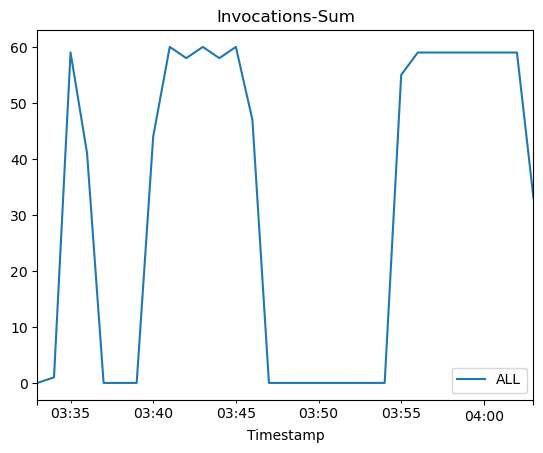

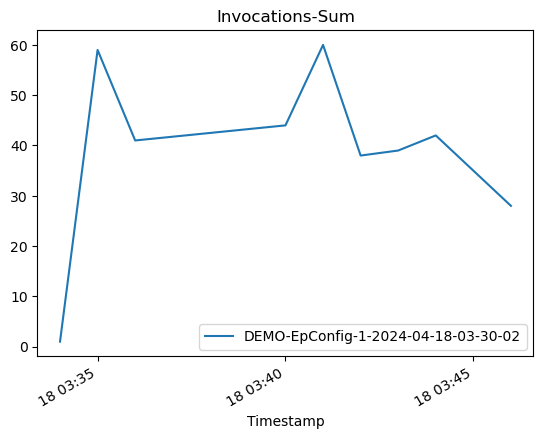

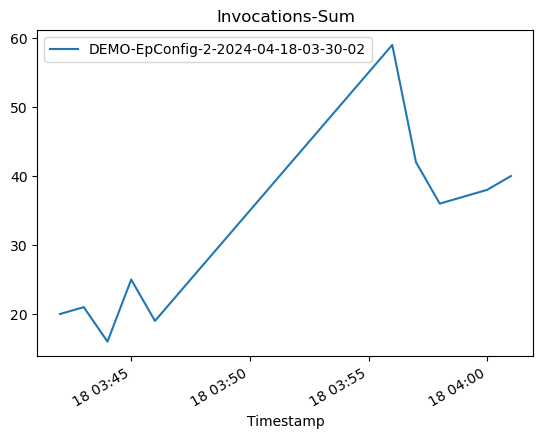

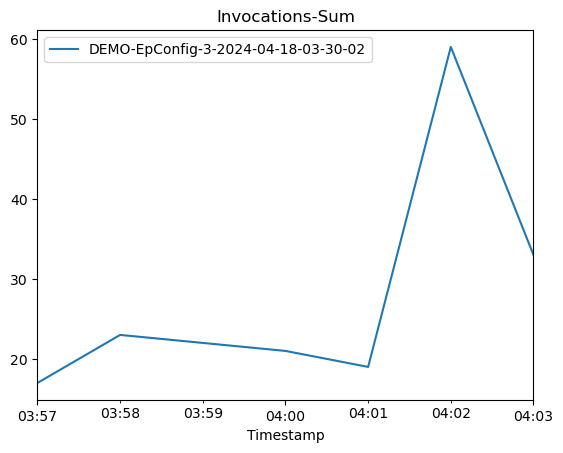

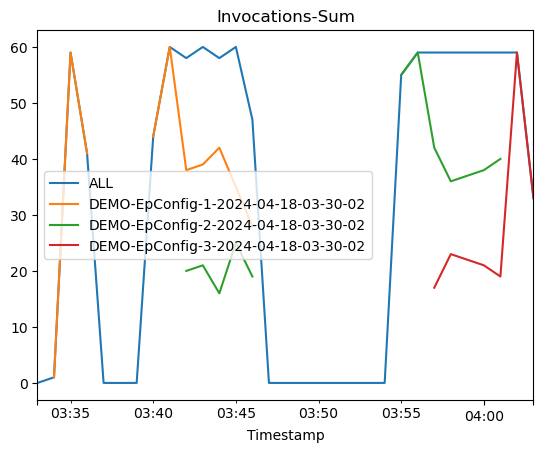

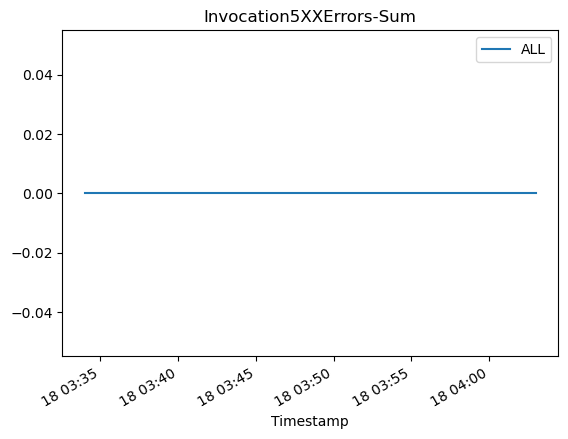

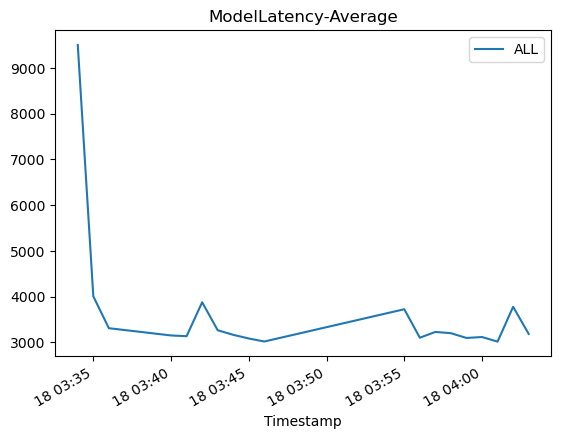

In [29]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_1 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_2 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name2, "AllTraffic", "Invocations", "Sum"
)
metrics_epc_3 = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name3, "AllTraffic", "Invocations", "Sum"
)

metrics_all = invocation_metrics.join([metrics_epc_1, metrics_epc_2, metrics_epc_3], how="outer")
metrics_all.plot(title="Invocations-Sum")

invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)

### Cleanup 
If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges and clean up other resources created in this notebook.

In [30]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '529c431a-7074-431f-8d01-b6567305709f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '529c431a-7074-431f-8d01-b6567305709f',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 18 Apr 2024 04:07:37 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [32]:
def invoke_endpoint(endpoint_name, should_raise_exp=False):
    with open("test_data/test_projeect.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                for i in range(10):  # send the same payload 10 times for testing purpose
                    response = sm_runtime.invoke_endpoint(
                        EndpointName=endpoint_name, ContentType="text/csv", Body=payload
                    )
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e


invoke_endpoint("humber-shadow1")

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

### RULE CONDITIONS(3)

#### Deploy shadow variants through code

#### Create two SageMaker models: one for your production variant, and one for your shadow variant.

In [45]:
import boto3
from sagemaker import get_execution_role, Session
                
aws_region = "us-east-1"

boto_session = boto3.Session(region_name=aws_region)
sagemaker_client = boto_session.client("sagemaker")

role = get_execution_role()

bucket = Session(boto_session).default_bucket()

model_name1 = "model1"
model_name2 = "model2"

sagemaker_client.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": image_uri,
            "ModelDataUrl": model_url
        }
    ]
)

sagemaker_client.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": image_uri2,
            "ModelDataUrl": model_url2 
        }
    ]
)


{'ModelArn': 'arn:aws:sagemaker:us-east-1:820129967772:model/model2',
 'ResponseMetadata': {'RequestId': '8b526e7a-d002-49de-a676-ba5636af8cc2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8b526e7a-d002-49de-a676-ba5636af8cc2',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '68',
   'date': 'Thu, 18 Apr 2024 05:45:15 GMT'},
  'RetryAttempts': 3}}

In [5]:
import boto3
from sagemaker import get_execution_role, Session

endpoint_config_name = "newendpoint1"  # Provide a new and unique name

aws_region = "us-east-1"
boto_session = boto3.Session(region_name=aws_region)

sagemaker_client = boto_session.client("sagemaker")
role = get_execution_role()
bucket = Session(boto_session).default_bucket()

create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "Production-01",
            "ModelName": "model1",
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ],
    ShadowProductionVariants=[
        {
            "VariantName": "shadow-01",
            "ModelName": "model2",
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ]
)


In [8]:
create_endpoint_response = sm.create_endpoint(
    EndpointName='newendpoint1',
    EndpointConfigName=endpoint_config_name,
)
